[<<< Previous: 01 Data Cleaning & Exploratory Data Analysis](./01_eda.ipynb)

<a id='top'></a>
# Detecting optic abnormalities through <br>Fundus photography
*First level screening tool to reduce man-hours spent on grading retinal images* | <br>
*An image classification model with binary outcomes*


## 02 Image Preprocessing

This notebook will cover the preprocessing steps before the image data are "fed" into the model.

### Contents
- [Setup](#setup)
- [Read Images](#read_img)
- [Crop Images](#crop_img)
- [Resize Images](#resize_img)
- [Save Image data](#save_img)

<a id='setup'></a>
### Setup


In [3]:
#for reproductibility
np.random.seed(42)

<a id='lib_imports'></a>
#### Library imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import asarray

import time
import os
import cv2

from PIL import Image
from IPython.display import display, Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

#my_functions module
import my_functions as myfunc
import importlib
importlib.reload(myfunc)

%matplotlib inline

Using TensorFlow backend.


<a id='data_imports'></a>
#### Data imports

In [4]:
df = pd.read_csv('../assets/data_v1.csv')

<a id='read_img'></a>
### Read Images

**Sample Image**

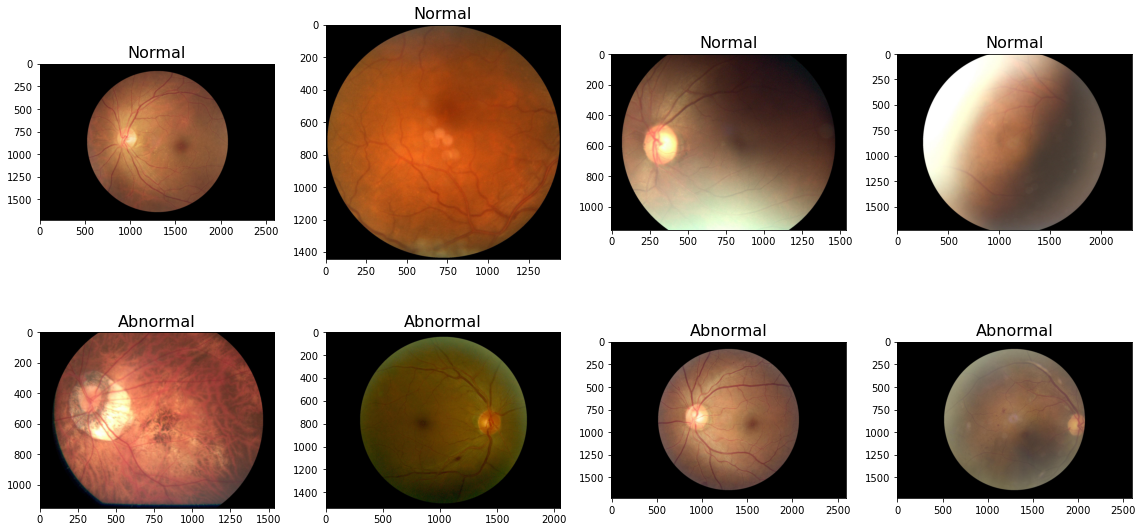

In [5]:
from PIL import Image

#preview category images
myfunc.sample_category_images('abnormal',4, df, 'filepath')

<a id='crop_img'></a>
### Crop images

**Crop Image function**
- Crop images to "reduce noise"
- Cropped based on empty row or column of pixels `≈ 0`

In [6]:
from PIL import Image

def crop_img(filepath):
'''
Parameters:
filepath: insert filepath of image to crop (path)
Docstring:
Crops image based on black (empty) edges
'''
    #opens and loads image using Pillow
    image=Image.open(filepath)
    image.load()
    
    #converts image to array
    image_data = np.asarray(image)
    #search for black edges 
    image_data_bw = image_data.max(axis=2)
    non_empty_columns = np.where(image_data_bw.max(axis=0)>0)[0]
    non_empty_rows = np.where(image_data_bw.max(axis=1)>0)[0]
   
    # creating cropbox based on black (empty) edges
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    
    #crop image
    image_data_new = image_data[cropBox[0]+10:cropBox[1]+1, cropBox[2]+15:cropBox[3]-9 , :]

    return image_data_new


**Applying Crop Image function on sample image**

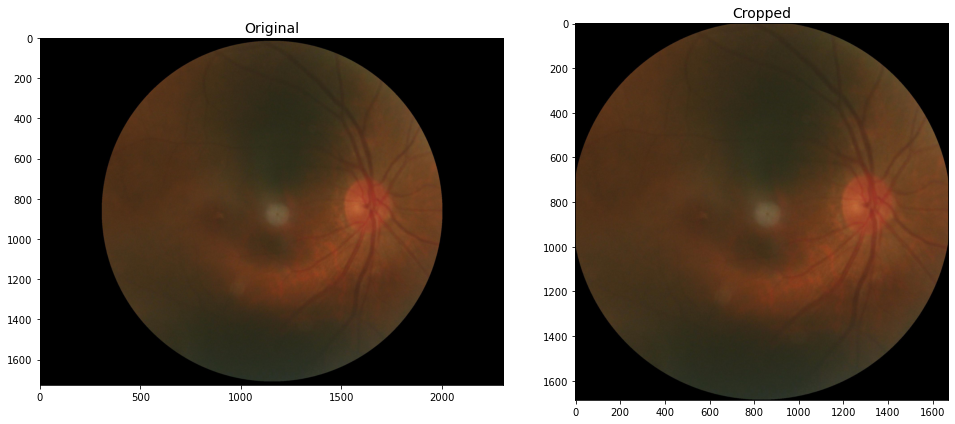

In [7]:
image = crop_img(df['filepath'].iloc[1])
f, ax = plt.subplots(nrows= 1, ncols=2, figsize=(14,6))
ax = ax.ravel()
ax[0].imshow(Image.open(df['filepath'].iloc[1]))
ax[0].set_title("Original", fontsize=14)
ax[1].imshow(image)
ax[1].set_title("Cropped", fontsize=14)
plt.tight_layout();

<a id='resize_img'></a>
### Resize images

In [8]:
#function to resize and pad image to maintain aspect ratio 
#im: image object as numpy array
#size_px: desired image size
def resize_pad(im, size_px):
    #set desired size
    desired_size = size_px

    old_size = im.shape[:2] # old_size is in (height, width) format
    #determine ratio of new size/old size
    ratio = float(desired_size)/max(old_size)

    # new_size should be in (width, height) format
    new_size = tuple([int(x*ratio) for x in old_size])

    #apply resize function
    im = cv2.resize(im, (new_size[1], new_size[0]))

    #calculating padded region
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    
    #apply padding
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    
    
    return new_im

**Applying Resize Pad Image function on sample image**

Note the change in axis!


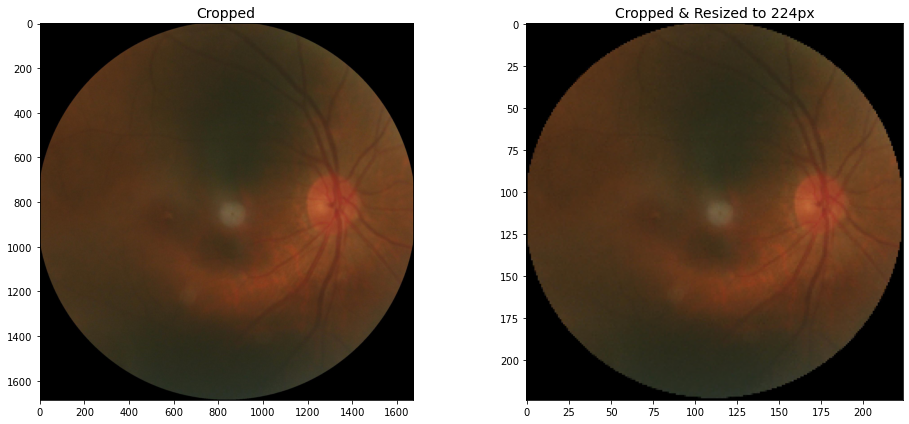

In [9]:
f, ax = plt.subplots(nrows= 1, ncols=2, figsize=(12,6))
ax = ax.ravel()
#plot cropped image
ax[0].imshow(image)
ax[0].set_title("Cropped", fontsize=14)
#plot resize image
ax[1].imshow(resize_pad(image, 224))
ax[1].set_title("Cropped & Resized to 224px", fontsize=14)
plt.tight_layout();
print("Note the change in axis!")

#### Preprocessing function

In [13]:
def run_preprocess(filepath, size_px):
    cropped_img = crop_img(filepath)
    final_img = resize_pad(cropped_img, size_px)
    return final_img

**Apply preprocessing function to dataset**

In [1]:
# try different image sizes

**Size 224 x 224**

In [10]:
df['img_224'] = df['filepath'].progress_map(lambda x: run_preprocess(x, 224))

100%|██████████| 6980/6980 [05:00<00:00, 23.25it/s]


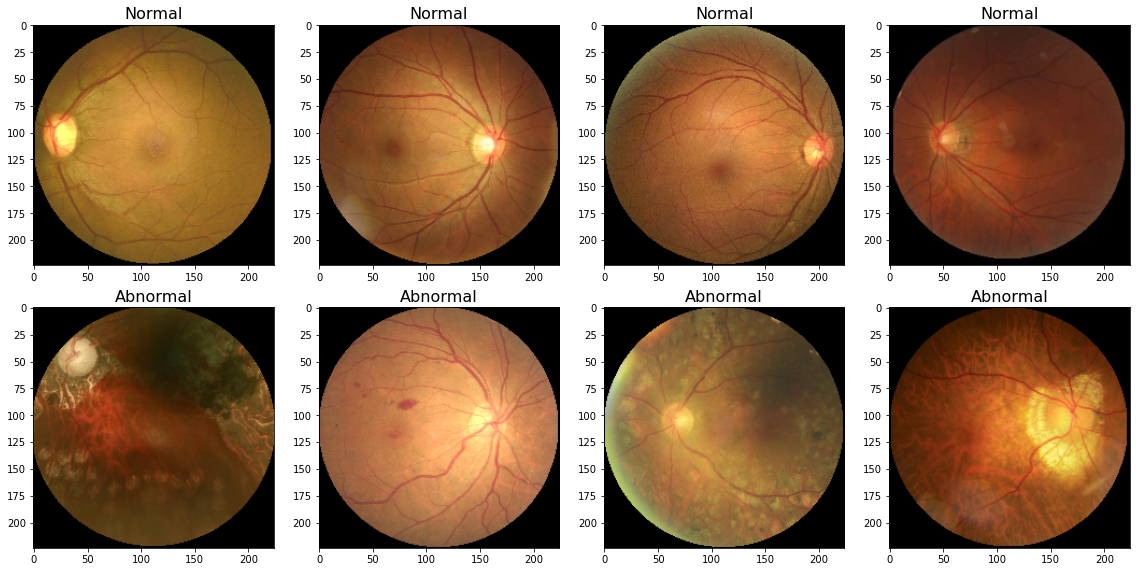

In [13]:
myfunc.sample_category_images('abnormal',4, df, 'img_224')

**Size 256 x 256**

In [17]:
df['img_256'] = df['filepath'].progress_map(lambda x: run_preprocess(x, 256))

100%|██████████| 6980/6980 [12:51<00:00,  9.04it/s]


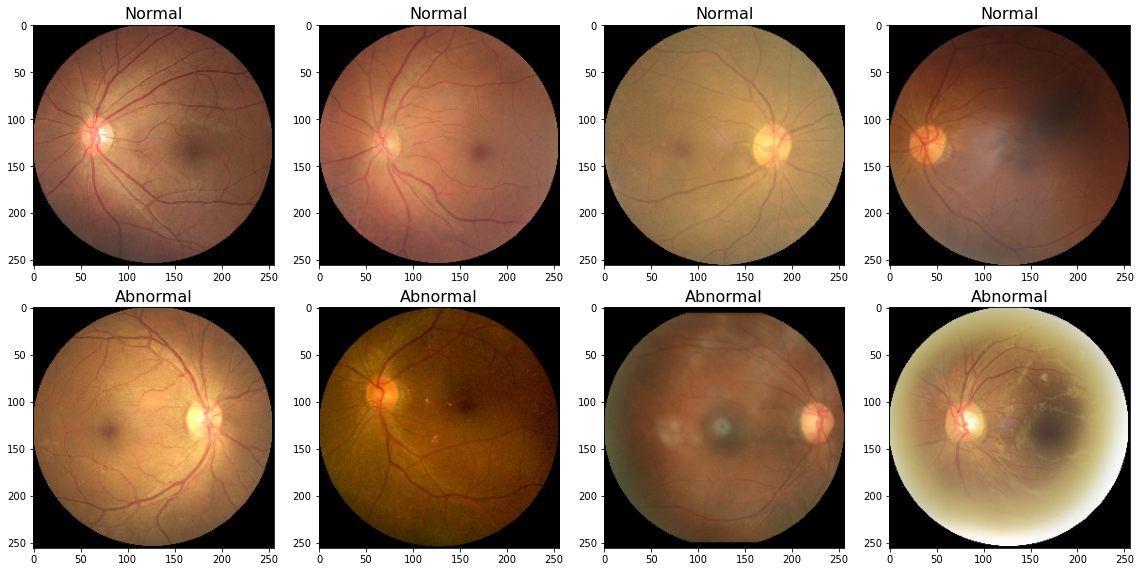

In [19]:
myfunc.sample_category_images('abnormal',4, df, 'img_256')

**Size 299 x 299**

In [14]:
%%time
tqdm.pandas()
df['img_299'] = df['filepath'].progress_map(lambda x: run_preprocess(x, 299))

100%|██████████| 6980/6980 [12:38<00:00,  9.20it/s]

CPU times: user 11min 7s, sys: 1min 18s, total: 12min 26s
Wall time: 12min 38s


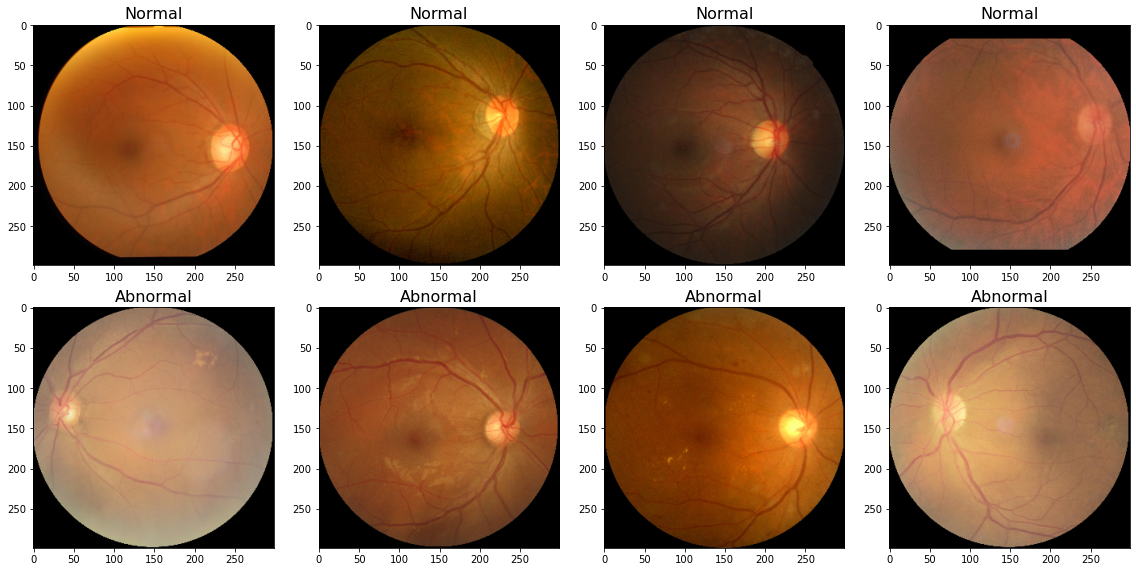

In [16]:
myfunc.sample_category_images('abnormal',4, df, 'img_299')

<a id='save_img'></a>
### Save Image data

In [11]:
img_224 = df['img_224'].values
# np.savez('../assets/img_224_data.npz',img_224=img_224)

In [18]:
#used for final model
img_256 = df['img_256'].values
np.savez('../assets/img_256_data.npz',img_256=img_256)

In [15]:
img_299 = df['img_299'].values
# np.savez('../assets/img_299_data.npz',img_299=img_299)

<div style="text-align: right">
<div class="right">
        <a href="./03_modelling.ipynb">>>> Next: 03 Modelling and Conclusion</a>
    </div>
    </div>

[Go to top](#top)

---